In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from base64 import b64decode

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import (
    Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization,
    Activation, MaxPooling2D
)
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from google.colab import files
from google.colab.output import eval_js
from IPython.display import display, Javascript

In [2]:
# Main Code ----------------------------------------------------------------------

In [3]:
!pip install kaggle

In [4]:
# Upload Kaggle credentials
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bellafrid","key":"47ae30791b3da542764c72b1a8380c06"}'}

In [5]:
# Move Kaggle credentials to appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download and unzip dataset from Kaggle
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip face-expression-recognition-dataset.zip -d /images

Utdata för streaming har trunkerats till de sista 5000 raderna.
  inflating: /images/images/validation/fear/8797.jpg  
  inflating: /images/images/validation/fear/8818.jpg  
  inflating: /images/images/validation/fear/886.jpg  
  inflating: /images/images/validation/fear/9037.jpg  
  inflating: /images/images/validation/fear/9040.jpg  
  inflating: /images/images/validation/fear/9101.jpg  
  inflating: /images/images/validation/fear/911.jpg  
  inflating: /images/images/validation/fear/9179.jpg  
  inflating: /images/images/validation/fear/9205.jpg  
  inflating: /images/images/validation/fear/9232.jpg  
  inflating: /images/images/validation/fear/9251.jpg  
  inflating: /images/images/validation/fear/9261.jpg  
  inflating: /images/images/validation/fear/9281.jpg  
  inflating: /images/images/validation/fear/9302.jpg  
  inflating: /images/images/validation/fear/9333.jpg  
  inflating: /images/images/validation/fear/9369.jpg  
  inflating: /images/images/validation/fear/9370.jpg  
  i

In [7]:
# Set size and path for images
picture_size = 48
base_path = "/images/images/"

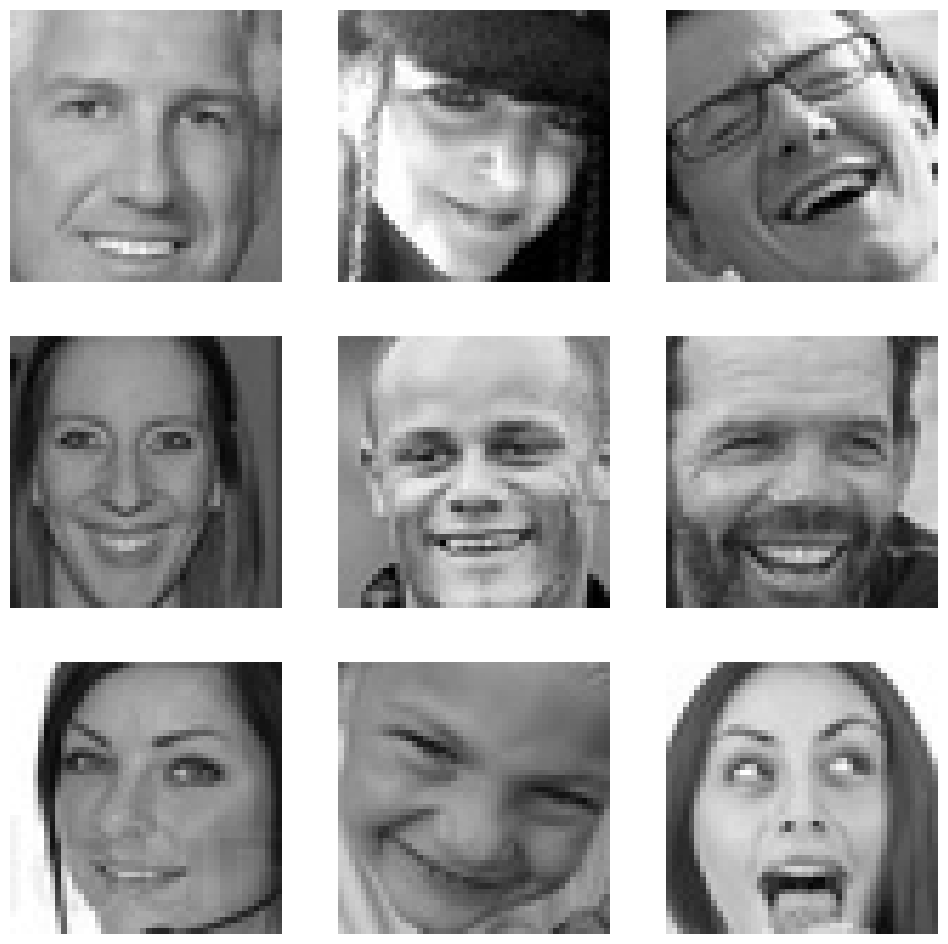

In [8]:
# Display expression "Happy" from training set
expression = 'happy'
expression_path = os.path.join(base_path, 'train', expression)
picture_size = 48

plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img_path = os.path.join(expression_path, os.listdir(expression_path)[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [26]:
batch_size  = 128

""" Data augmentation for better generalization - removed due to lowered results
datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator()"""

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

# Generate batches of tensor image data from the training and validation directory
train_set = datagen_train.flow_from_directory(base_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(base_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [27]:
no_of_classes = 7

model = Sequential()

# 1st layer: Initialize with more filters for detailed feature extraction and regularization
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

# 2nd layer: Increase filters to capture more complex features
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 3rd layer: Further increase filters for capturing intricate details
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 4th layer: Added to capture even more complex features
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 5th layer: Added to increase the depth of the network for better feature extraction
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Convert 3D feature maps to 1D feature vectors
model.add(Flatten())

# Fully connected 1st layer: Added to learn combinations of the high-level features
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 2nd layer: Added to further refine the learned features
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer: Added to produce the final classification output
model.add(Dense(no_of_classes, activation='softmax'))

# Used a lower learning rate to ensure stable convergence
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [28]:
# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Stop training early if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Reduce learning rate when a metric has stopped improving
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

# List of callbacks to pass to the model during training
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

# Set the number of epochs to train the model
epochs = 48

# Compile the model with the specified loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [30]:
# Train the model using a data generator for the training set
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/48
  1/225 [..............................] - ETA: 22s - loss: 1.2143 - accuracy: 0.5391

<ipython-input-30-d49a6de4e885>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


225/225 [==============================] - ETA: 0s - loss: 1.2206 - accuracy: 0.5357

225/225 [==============================] - 16s 70ms/step - loss: 1.2206 - accuracy: 0.5357 - val_loss: 1.1728 - val_accuracy: 0.5416 - lr: 2.0000e-04
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.1836 - accuracy: 0.5489

225/225 [==============================] - 16s 71ms/step - loss: 1.1836 - accuracy: 0.5489 - val_loss: 1.1171 - val_accuracy: 0.5720 - lr: 2.0000e-04
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.1604 - accuracy: 0.5578

225/225 [==============================] - 15s 67ms/step - loss: 1.1604 - accuracy: 0.5578 - val_loss: 1.1129 - val_accuracy: 0.5737 - lr: 2.0000e-04
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 1.1390 - accuracy: 0.5679

225/225 [==============================] - 15s 67ms/step - loss: 1.1390 - accuracy: 0.5679 - val_loss: 1.1094 - val_accuracy: 0.5774 - lr: 2.0000e-04
Epoch 5/48
225/225 [==============================] - ETA: 0s - loss: 1.1264 - accuracy: 0.5760

225/225 [==============================] - 15s 67ms/step - loss: 1.1264 - accuracy: 0.5760 - val_loss: 1.1549 - val_accuracy: 0.5688 - lr: 2.0000e-04
Epoch 6/48
225/225 [==============================] - ETA: 0s - loss: 1.1121 - accuracy: 0.5786

225/225 [==============================] - 16s 73ms/step - loss: 1.1121 - accuracy: 0.5786 - val_loss: 1.0814 - val_accuracy: 0.5879 - lr: 2.0000e-04
Epoch 7/48
225/225 [==============================] - ETA: 0s - loss: 1.0927 - accuracy: 0.5879

225/225 [==============================] - 16s 70ms/step - loss: 1.0927 - accuracy: 0.5879 - val_loss: 1.0583 - val_accuracy: 0.6031 - lr: 2.0000e-04
Epoch 8/48
225/225 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.5967

225/225 [==============================] - 15s 67ms/step - loss: 1.0727 - accuracy: 0.5967 - val_loss: 1.0534 - val_accuracy: 0.5997 - lr: 2.0000e-04
Epoch 9/48
224/225 [============================>.] - ETA: 0s - loss: 1.0575 - accuracy: 0.5998

225/225 [==============================] - 15s 66ms/step - loss: 1.0575 - accuracy: 0.5997 - val_loss: 1.0777 - val_accuracy: 0.5952 - lr: 2.0000e-04
Epoch 10/48
225/225 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.6075

225/225 [==============================] - 15s 66ms/step - loss: 1.0388 - accuracy: 0.6075 - val_loss: 1.0438 - val_accuracy: 0.6028 - lr: 2.0000e-04
Epoch 11/48
225/225 [==============================] - ETA: 0s - loss: 1.0268 - accuracy: 0.6128

225/225 [==============================] - 16s 70ms/step - loss: 1.0268 - accuracy: 0.6128 - val_loss: 1.0372 - val_accuracy: 0.6070 - lr: 2.0000e-04
Epoch 12/48
225/225 [==============================] - ETA: 0s - loss: 1.0038 - accuracy: 0.6246

225/225 [==============================] - 15s 67ms/step - loss: 1.0038 - accuracy: 0.6246 - val_loss: 1.0327 - val_accuracy: 0.6125 - lr: 2.0000e-04
Epoch 13/48
225/225 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.6299

225/225 [==============================] - 15s 67ms/step - loss: 0.9897 - accuracy: 0.6299 - val_loss: 1.0334 - val_accuracy: 0.6170 - lr: 2.0000e-04
Epoch 14/48
225/225 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6351

225/225 [==============================] - 15s 67ms/step - loss: 0.9789 - accuracy: 0.6351 - val_loss: 1.0131 - val_accuracy: 0.6249 - lr: 2.0000e-04
Epoch 15/48
225/225 [==============================] - ETA: 0s - loss: 0.9679 - accuracy: 0.6387

225/225 [==============================] - 15s 69ms/step - loss: 0.9679 - accuracy: 0.6387 - val_loss: 1.1127 - val_accuracy: 0.5893 - lr: 2.0000e-04
Epoch 16/48
225/225 [==============================] - ETA: 0s - loss: 0.9539 - accuracy: 0.6443

225/225 [==============================] - 15s 67ms/step - loss: 0.9539 - accuracy: 0.6443 - val_loss: 1.0356 - val_accuracy: 0.6153 - lr: 2.0000e-04
Epoch 17/48
225/225 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.6477Restoring model weights from the end of the best epoch: 14.



Epoch 17: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
225/225 [==============================] - 15s 67ms/step - loss: 0.9358 - accuracy: 0.6477 - val_loss: 1.0461 - val_accuracy: 0.6178 - lr: 2.0000e-04
Epoch 17: early stopping


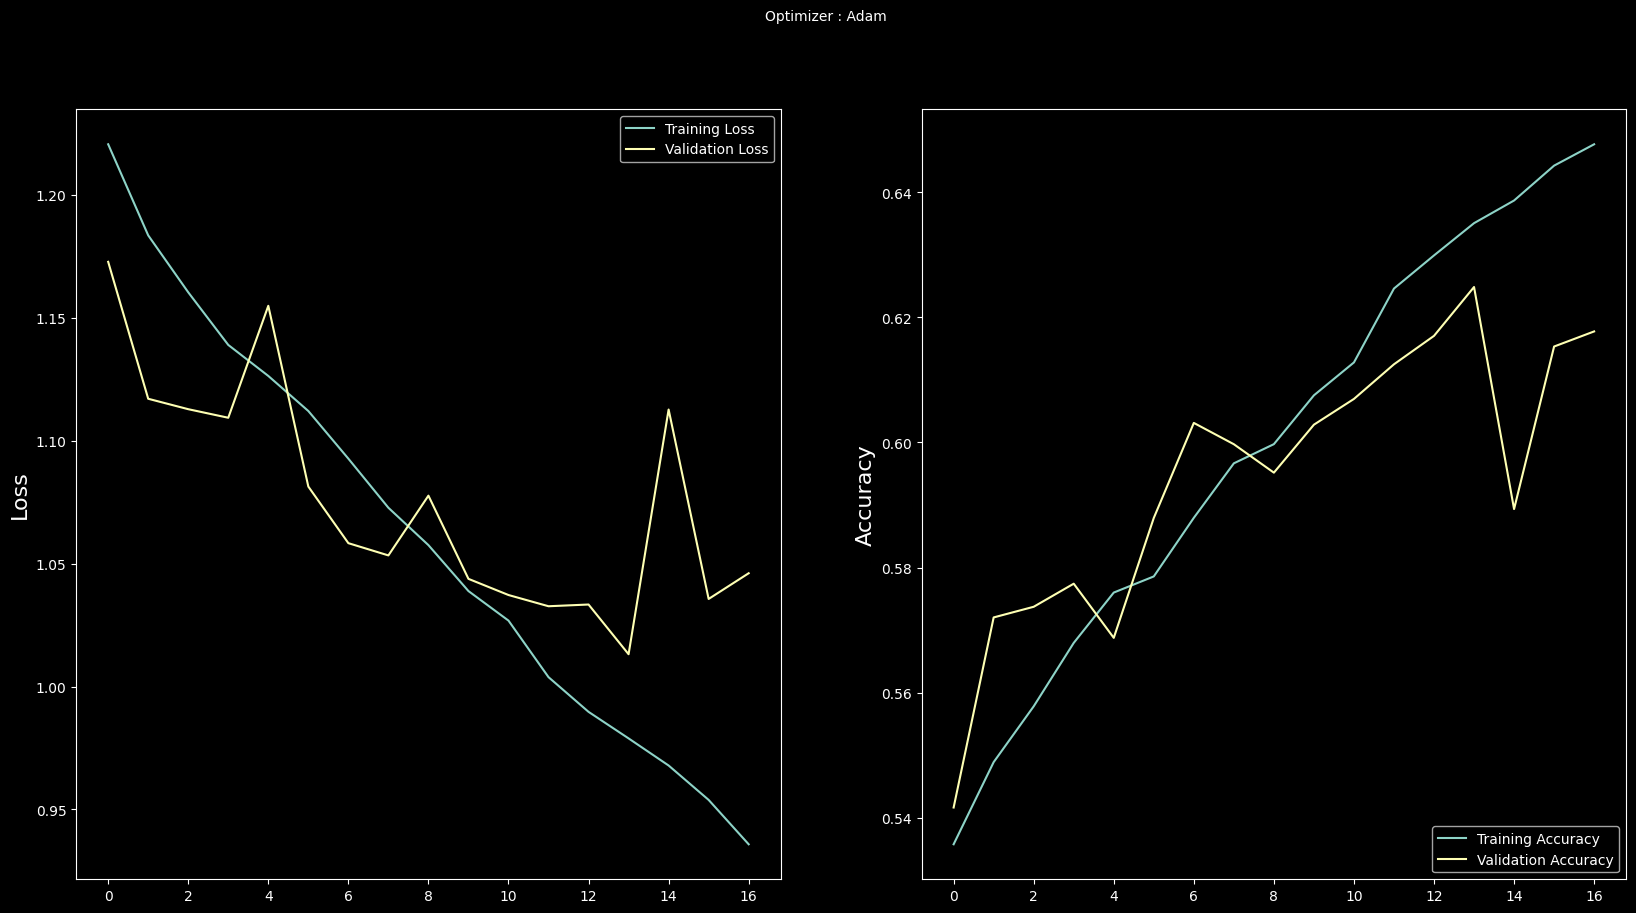

In [31]:
plt.style.use('dark_background')
plt.figure(figsize=(20,10))

# Create a subplot for the loss curves
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Create a subplot for the accuracy curves
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

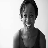

In [47]:
# Load my own images
# img_path = '/content/sad.jpeg'
# img_path = '/content/surprise.jpeg'
img_path = '/content/happy.jpeg'
# img_path = '/content/neutral.jpeg'
# img_path = '/content/fear.jpeg'
# img_path = '/content/disgust.jpeg'
# img_path = '/content/surprise.jpeg'

img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
img

In [48]:
# Converting image to array, and expand dimensions
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [49]:
# Predicting my uploaded image
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

preds = model.predict(x)
predicted_label = emotion_labels[np.argmax(preds)]

print('Predicted:', predicted_label)

1/1 [==============================] - 0s 19ms/step
Predicted: Neutral


In [35]:
# Function Definitions ----------------------------------------------------------

In [39]:
# Instead of the live video prediction, I used JavaScript to be able to use the camera in Colab
def capture_frame():
    js = Javascript('''
        async function captureFrame() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('captureFrame()')
    binary = b64decode(data.split(',')[1])
    with open('/captured_frame.jpg', 'wb') as f:
        f.write(binary)
    return '/captured_frame.jpg'

classifier = load_model('/content/model.h5')

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

def predict_emotion(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    preds = classifier.predict(x)
    predicted_label = emotion_labels[np.argmax(preds)]
    return predicted_label

#Loop to continue predicting
while True:
    img_path = capture_frame()
    predicted_emotion = predict_emotion(img_path)
    print('Predicted Emotion:', predicted_emotion)
    user_input = input("Press Enter to continue or 'q' to quit: ")
    if user_input.lower() == 'q':
        break


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 215ms/step
Predicted Emotion: Sad
Press Enter to continue or 'q' to quit: 


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 18ms/step
Predicted Emotion: Sad
Press Enter to continue or 'q' to quit: 


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 43ms/step
Predicted Emotion: Fear
Press Enter to continue or 'q' to quit: 


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 28ms/step
Predicted Emotion: Sad
Press Enter to continue or 'q' to quit: 


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 28ms/step
Predicted Emotion: Neutral
Press Enter to continue or 'q' to quit: q


As my understanding, I can't run this code in Google Colab, but I wanted to add it for show.

In [44]:
face_classifier = cv2.CascadeClassifier(r'/content/haarcascade_frontalface_default.xml')
classifier =load_model(r'/content/model.h5')

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)



while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)



        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            prediction = classifier.predict(roi)[0]
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [45]:
filenames = os.listdir(cv2.data.haarcascades)
filenames = sorted(filenames)
print('\n'.join(filenames))

__init__.py
__pycache__
haarcascade_eye.xml
haarcascade_eye_tree_eyeglasses.xml
haarcascade_frontalcatface.xml
haarcascade_frontalcatface_extended.xml
haarcascade_frontalface_alt.xml
haarcascade_frontalface_alt2.xml
haarcascade_frontalface_alt_tree.xml
haarcascade_frontalface_default.xml
haarcascade_fullbody.xml
haarcascade_lefteye_2splits.xml
haarcascade_license_plate_rus_16stages.xml
haarcascade_lowerbody.xml
haarcascade_profileface.xml
haarcascade_righteye_2splits.xml
haarcascade_russian_plate_number.xml
haarcascade_smile.xml
haarcascade_upperbody.xml


1.	Utmaningar du haft under arbetet samt hur du hanterat dem.
- Jag har inte haft så mycket utmaningar med denna kurs. Jag råkade använda en CNN modell under Maskininlärningskursen och lärde mig mycket då av mina misstag. Jag trodde dock att GPU var automatiskt på i Colab och fick vänta 8 timmar på att 12 epocher skulle köras (innan avbrutet). Jag började googla lite och insåg att jag måste ändra körningstypen manuellt och 8 timmar gick ner till en minut. Man kan heller inte använda GPU så ofta och jag har fått vänta in när jag kan köra koden vilket inte har varit så smidigt.

2.	Vilket betyg du anser att du skall ha och varför.
- Jag hoppas att jag har visat tillräckligt med kunskaper för G, och att det jag har lagt till kan leda till högre betyg.

3.	Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den.
- Börja med kunskapskontrollen tidigare än en dag innan inlämning.


Tack för den här kursen! 🙏